In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from featexp import get_univariate_plots

# Preprocessing

### Create Modeling Datasets

In [37]:
# Imputes zeros for nulls in original dataset

raw_df = pd.read_csv("inputs/BlackFriday.csv")
df = raw_df.rename(columns =   {'User_ID' : 'u_id',
                            'Product_ID' : 'p_id',
                            'Gender' : 'gender',
                            'Age' : 'age',
                            'Occupation' : 'occ',
                            'City_Category' : 'city',
                            'Stay_In_Current_City_Years' : 'years_in_city',
                            'Marital_Status' : 'married',
                            'Product_Category_1' : 'p_cat_1',
                            'Product_Category_2' : 'p_cat_2',
                            'Product_Category_3' : 'p_cat_3',
                            'Purchase' : 'pur'})
df.to_csv("inputs/imputed_black_friday.csv", encoding='utf-8', index = False)
df.head()

,u_id,p_id,gender,age,occ,city,years_in_city,married,p_cat_1,p_cat_2,p_cat_3,pur
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [73]:
minimal_preprocess = 0
some_one_hot = 1
all_one_hot = 2

chosen = all_one_hot

In [74]:
df = pd.read_csv("inputs/imputed_black_friday.csv")
file_name = ""
modeldf = df
cols = np.asarray(df.columns)

modeldf['u_id'] = modeldf['u_id'] - 1000000
modeldf['p_id'] = modeldf['p_id'].replace('[A-Za-z]', '', regex = True)
modeldf['p_id'] = pd.to_numeric(modeldf.p_id, errors='coerce')
modeldf['p_cat_2'].fillna(0, inplace = True)
modeldf['p_cat_3'].fillna(0, inplace = True)
modeldf['p_cat_2'] = modeldf['p_cat_2'].astype(int)
modeldf['p_cat_3'] = modeldf['p_cat_3'].astype(int)

if chosen == minimal_preprocess:
    # Creates dataset with imputed 0s and labelvector on age
    #df['p_cat_2'].fillna(df['p_cat_2'].mean(), inplace = True)
    #df['p_cat_3'].fillna(df['p_cat_3'].mean(), inplace = True)
    label_features = ['gender', 'age', 'years_in_city', 'city']
    for feature in label_features:
        ranges = pd.unique(pd.Series(df[feature]))
        ranges.sort()
        mapped = [x for x in range(len(ranges))]
        modeldf[feature] = modeldf[feature].map(dict(zip(ranges, mapped)))
    file_name = "minimal_preprocess.csv"
elif chosen == some_one_hot:
    # Creates dataset with one hot vectors except on age
    one_hot_features = ['occ', 'city', 'p_cat_1', 'p_cat_2', 'p_cat_3']
    for feature in one_hot_features:
        if feature in cols:
            ranges = pd.unique(pd.Series(modeldf[feature]))
            ranges.sort()
            mapped = [feature + '_' + str(x) for x in range(len(ranges))]
            modeldf[feature] = modeldf[feature].map(dict(zip(ranges, mapped)))
            one_hot = pd.get_dummies(modeldf[feature])
            modeldf = modeldf.drop(feature, axis = 1)
            modeldf = modeldf.join(one_hot)

    label_features = ['gender', 'age', 'years_in_city']

    for feature in label_features:
        ranges = pd.unique(pd.Series(df[feature]))
        ranges.sort()
        mapped = [x for x in range(len(ranges))]
        modeldf[feature] = modeldf[feature].map(dict(zip(ranges, mapped)))
    file_name = "some_one_hot.csv"
elif chosen == all_one_hot:
    # creates dataset with one hot vectors on all applicable
    cat_features = ['age', 'occ', 'city', 'p_cat_1', 'p_cat_2', 'p_cat_3', 'years_in_city']
    for cat in cat_features:
        if cat in cols:
            ranges = pd.unique(pd.Series(modeldf[cat]))
            ranges.sort()
            mapped = [cat + '_' + str(x) for x in range(len(ranges))]
            modeldf[cat] = modeldf[cat].map(dict(zip(ranges, mapped)))
            one_hot = pd.get_dummies(modeldf[cat])
            modeldf = modeldf.drop(cat, axis = 1)
            modeldf = modeldf.join(one_hot)

    label_features = ['gender']

    for feature in label_features:
        ranges = pd.unique(pd.Series(df[feature]))
        ranges.sort()
        mapped = [str(x) for x in range(len(ranges))]
        modeldf[feature] = modeldf[feature].map(dict(zip(ranges, mapped)))
    file_name = "all_one_hot.csv"

if len(file_name) != 0:
    modeldf.to_csv("inputs/" + file_name , encoding='utf-8', index = False)

modeldf.head()

,u_id,p_id,gender,married,pur,age_0,age_1,age_2,age_3,age_4,...,p_cat_3_5,p_cat_3_6,p_cat_3_7,p_cat_3_8,p_cat_3_9,years_in_city_0,years_in_city_1,years_in_city_2,years_in_city_3,years_in_city_4
0,1,69042,0,0,8370,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,248942,0,0,15200,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,87842,0,0,1422,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,85442,0,0,1057,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2,285442,1,0,7969,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Choose Modeling Dataset to Use

In [9]:
minimal_preprocess = 0
some_one_hot = 1
all_one_hot = 2

chosen = all_one_hot

In [10]:
non_features = ['u_id', 'p_id']
demo_cols = []
predictor = ['pur']
modeldf = 0
file_name = ""

if chosen == minimal_preprocess:
    file_name = "minimal_preprocess.csv"
    demo_cols = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']
elif chosen == some_one_hot:
    file_name = "some_one_hot.csv"
    demo_cols = ['gender', 'age', 'years_in_city', 'married', 'occ_0', 'occ_1', 'occ_10',
           'occ_11', 'occ_12', 'occ_13', 'occ_14', 'occ_15', 'occ_16', 'occ_17',
           'occ_18', 'occ_19', 'occ_2', 'occ_20', 'occ_3', 'occ_4', 'occ_5',
           'occ_6', 'occ_7', 'occ_8', 'occ_9', 'city_0', 'city_1', 'city_2']
elif chosen == all_one_hot:
    file_name = "all_one_hot.csv"
    demo_cols = ['gender', 'married', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4',
           'age_5', 'age_6', 'occ_0', 'occ_1', 'occ_10', 'occ_11', 'occ_12',
           'occ_13', 'occ_14', 'occ_15', 'occ_16', 'occ_17', 'occ_18', 'occ_19',
           'occ_2', 'occ_20', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_7', 'occ_8',
           'occ_9', 'city_0', 'city_1', 'city_2',
           'years_in_city_0', 'years_in_city_1', 'years_in_city_2',
           'years_in_city_3', 'years_in_city_4']
    
modeldf = pd.read_csv("inputs/" + file_name)
modeldf = modeldf.drop(non_features, axis = 1)
#modeldf = modeldf[modeldf["pur"] < modeldf["pur"].quantile(0.99)]
X = modeldf.drop(predictor, axis = 1)
y = modeldf[predictor]
modeldf.head()

,gender,married,pur,age_0,age_1,age_2,age_3,age_4,age_5,age_6,...,p_cat_3_5,p_cat_3_6,p_cat_3_7,p_cat_3_8,p_cat_3_9,years_in_city_0,years_in_city_1,years_in_city_2,years_in_city_3,years_in_city_4
0,0,0,8370,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,15200,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1422,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1057,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,7969,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


# Exploration

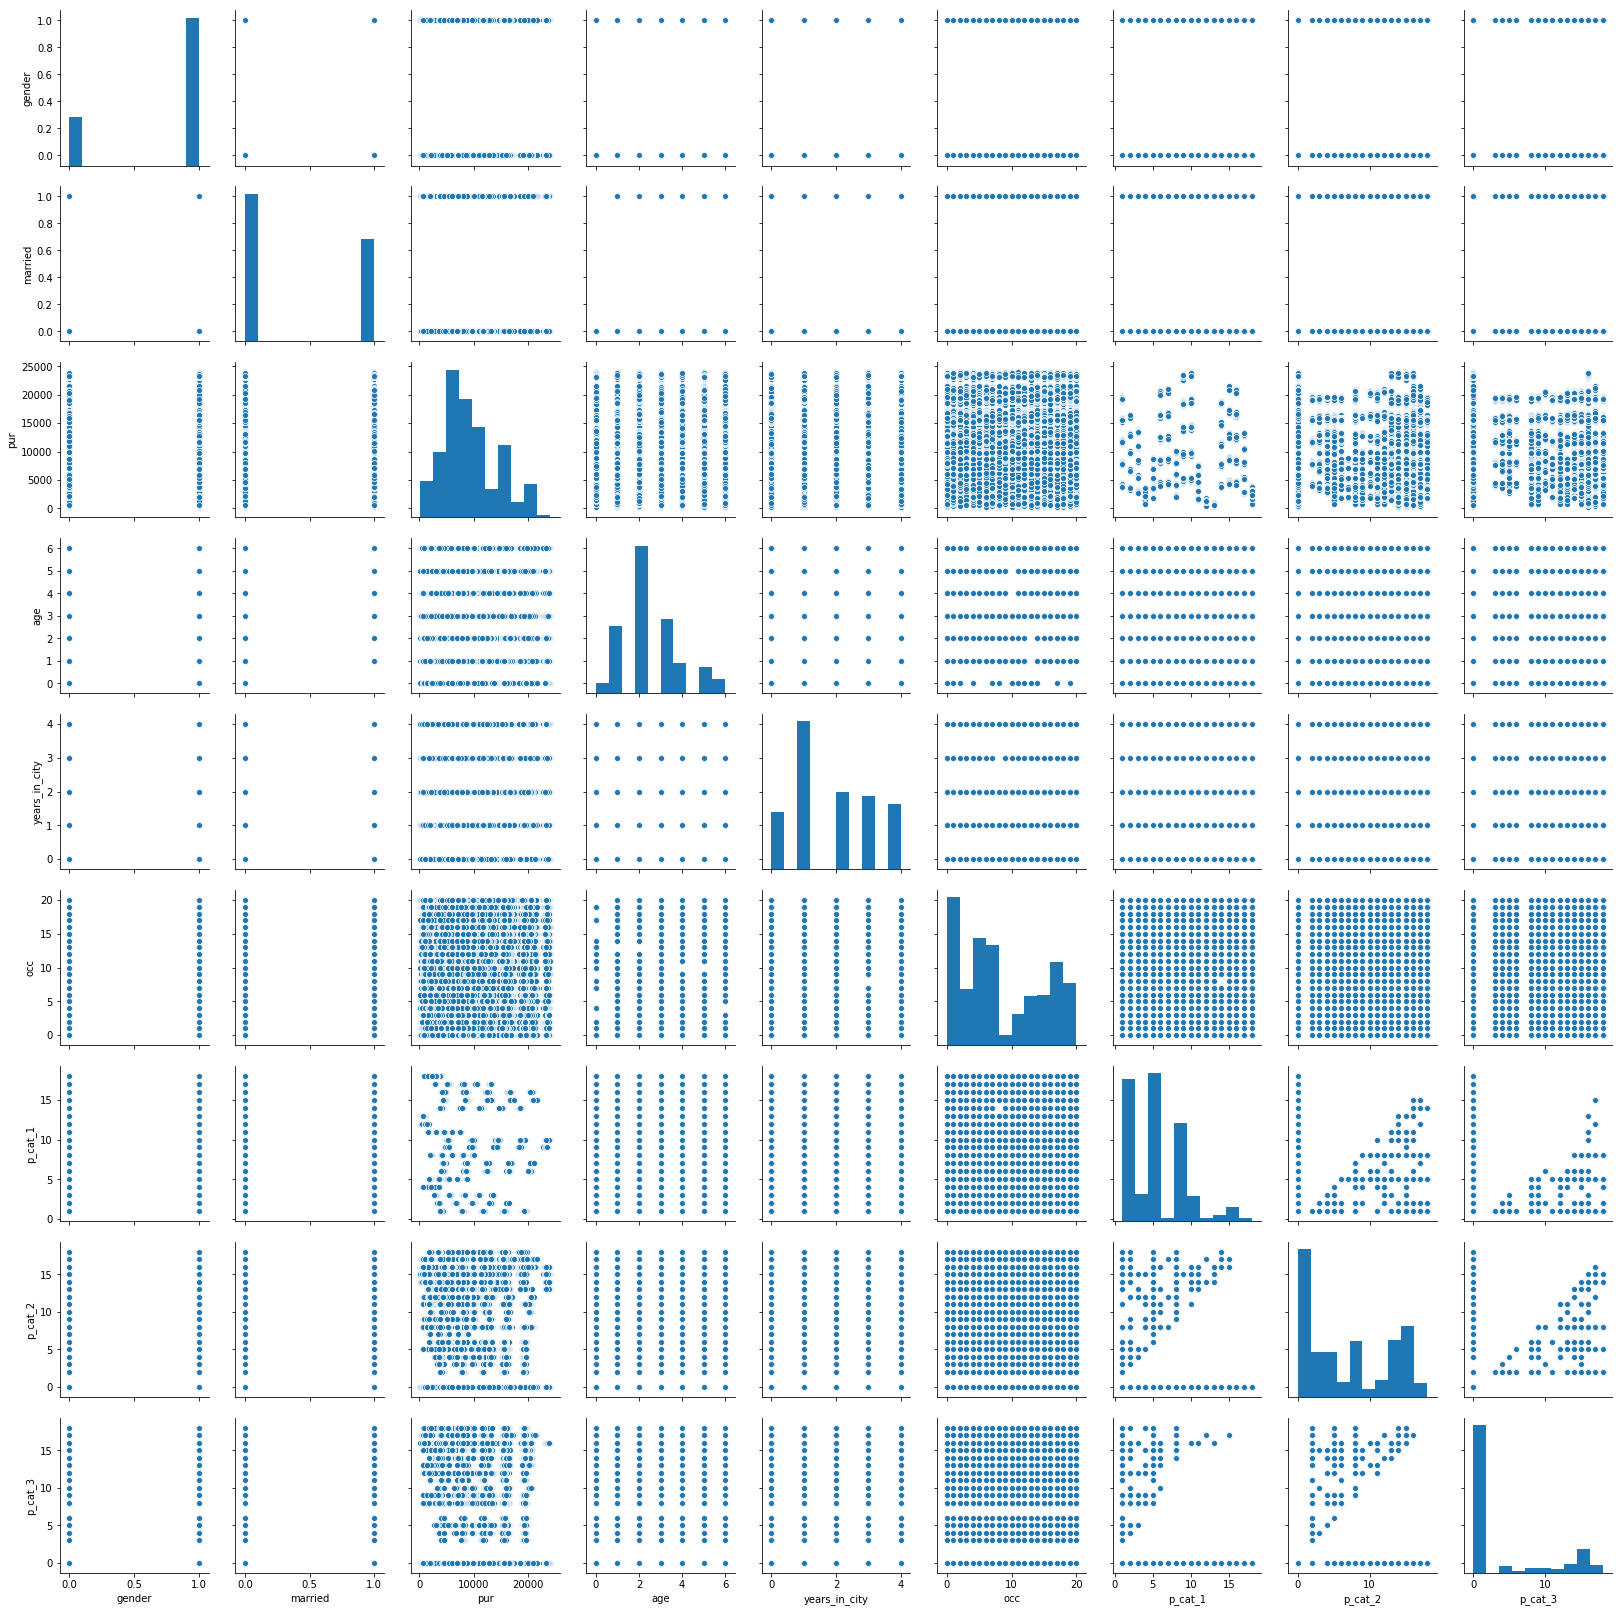

In [41]:
pairs = ['gender', 'married', 'pur', 'age', 'years_in_city', 'occ', 'p_cat_1', 'p_cat_2', 'p_cat_3']
sns.pairplot(modeldf[pairs])

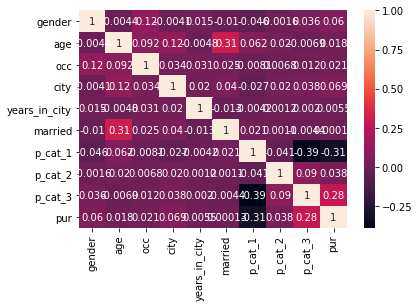

In [68]:
sns.heatmap(modeldf.corr(), annot = True)

In [8]:
from sklearn import preprocessing
cats = ['p_cat_1', 'p_cat_2', 'p_cat_3']
le = preprocessing.LabelEncoder()
temp = modeldf
temp[cats].apply(le.fit_transform)

,p_cat_1,p_cat_2,p_cat_3
0,2,8,9
1,0,4,11
2,11,8,9
3,11,13,9
4,7,8,9
5,0,0,9
6,0,6,14
7,0,14,9
8,0,15,9
9,7,8,9


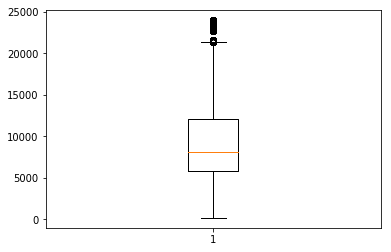

In [89]:
plt.boxplot(modeldf['pur'])
plt.show()

In [10]:
modeldf.describe()

,gender,age,occ,city,years_in_city,married,p_cat_1,p_cat_2,p_cat_3,pur
count,537577.000000,537577.000000,537577.00000,537577.000000,537577.000000,537577.000000,537577.000000,537577.000000,537577.000000,537577.000000
mean,0.754087,2.494755,8.08271,1.040567,1.859458,0.408797,5.295546,9.842144,12.669840,9333.859853
std,0.430627,1.352583,6.52412,0.759627,1.289828,0.491612,3.750701,4.223872,2.279938,4981.022133
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,185.000000
25%,1.000000,2.000000,2.00000,0.000000,1.000000,0.000000,1.000000,8.000000,12.669840,5866.000000
50%,1.000000,2.000000,7.00000,1.000000,2.000000,0.000000,5.000000,9.842144,12.669840,8062.000000
75%,1.000000,3.000000,14.00000,2.000000,3.000000,1.000000,8.000000,14.000000,12.669840,12073.000000
max,1.000000,6.000000,20.00000,2.000000,4.000000,1.000000,18.000000,18.000000,18.000000,23961.000000


In [4]:
# splits datasets based on demographics specified
cats = ["p_cat_1", "p_cat_2", "p_cat_3"]
cluster_splits = cats


temp = [modeldf]
first = True
for split in cluster_splits:
    other_temp = []
    for other in temp:
        other_temp.append([other[other[split] == x] for x in range(min(other[split]), max(other[split]) + 1)])
    if first:
        temp = other_temp[0]
        first = False
    else:
        temp = []
        for other in other_temp:
            for some_other in other:
                if not some_other.empty:
                    temp.append(some_other)

custom_clusters = sorted(temp, key=len)

<BarContainer object of 235 artists>

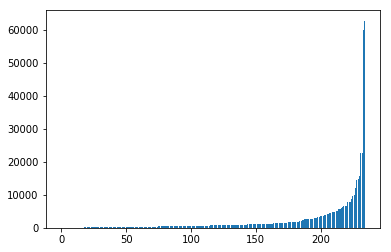

In [55]:
plt.bar(range(len(custom_clusters)), [len(x) for x in custom_clusters])

In [5]:
lower = .80
upper = 1

trimmed_modeldf = pd.concat(custom_clusters[int(len(custom_clusters) * lower) : int(len(custom_clusters) * upper - 1)])

In [6]:
trimmed_modeldf

,gender,age,occ,city,years_in_city,married,p_cat_1,p_cat_2,p_cat_3,pur
299,0,0,10,2,2,0,15,16,0,17271
354,1,2,2,1,3,0,15,16,0,12850
584,1,1,12,2,2,0,15,16,0,12790
656,0,4,3,2,1,1,15,16,0,17320
1365,0,2,4,0,0,0,15,16,0,17189
1511,1,3,16,1,0,0,15,16,0,13156
1979,1,6,13,2,1,0,15,16,0,17358
3069,1,2,12,1,0,0,15,16,0,16827
3111,1,2,0,2,4,0,15,16,0,16846
3799,1,5,2,2,2,1,15,16,0,8985


In [7]:
# splits datasets based on demographics specified
cluster_splits = ['gender', 'age', 'married']

temp = [trimmed_modeldf]
first = True
for split in cluster_splits:
    other_temp = []
    for other in temp:
        other_temp.append([other[other[split] == x] for x in range(min(other[split]), max(other[split]) + 1)])
    if first:
        temp = other_temp[0]
        first = False
    else:
        temp = []
        for other in other_temp:
            for some_other in other:
                if not some_other.empty:
                    temp.append(some_other)

custom_clusters = sorted(temp, key=len)

C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


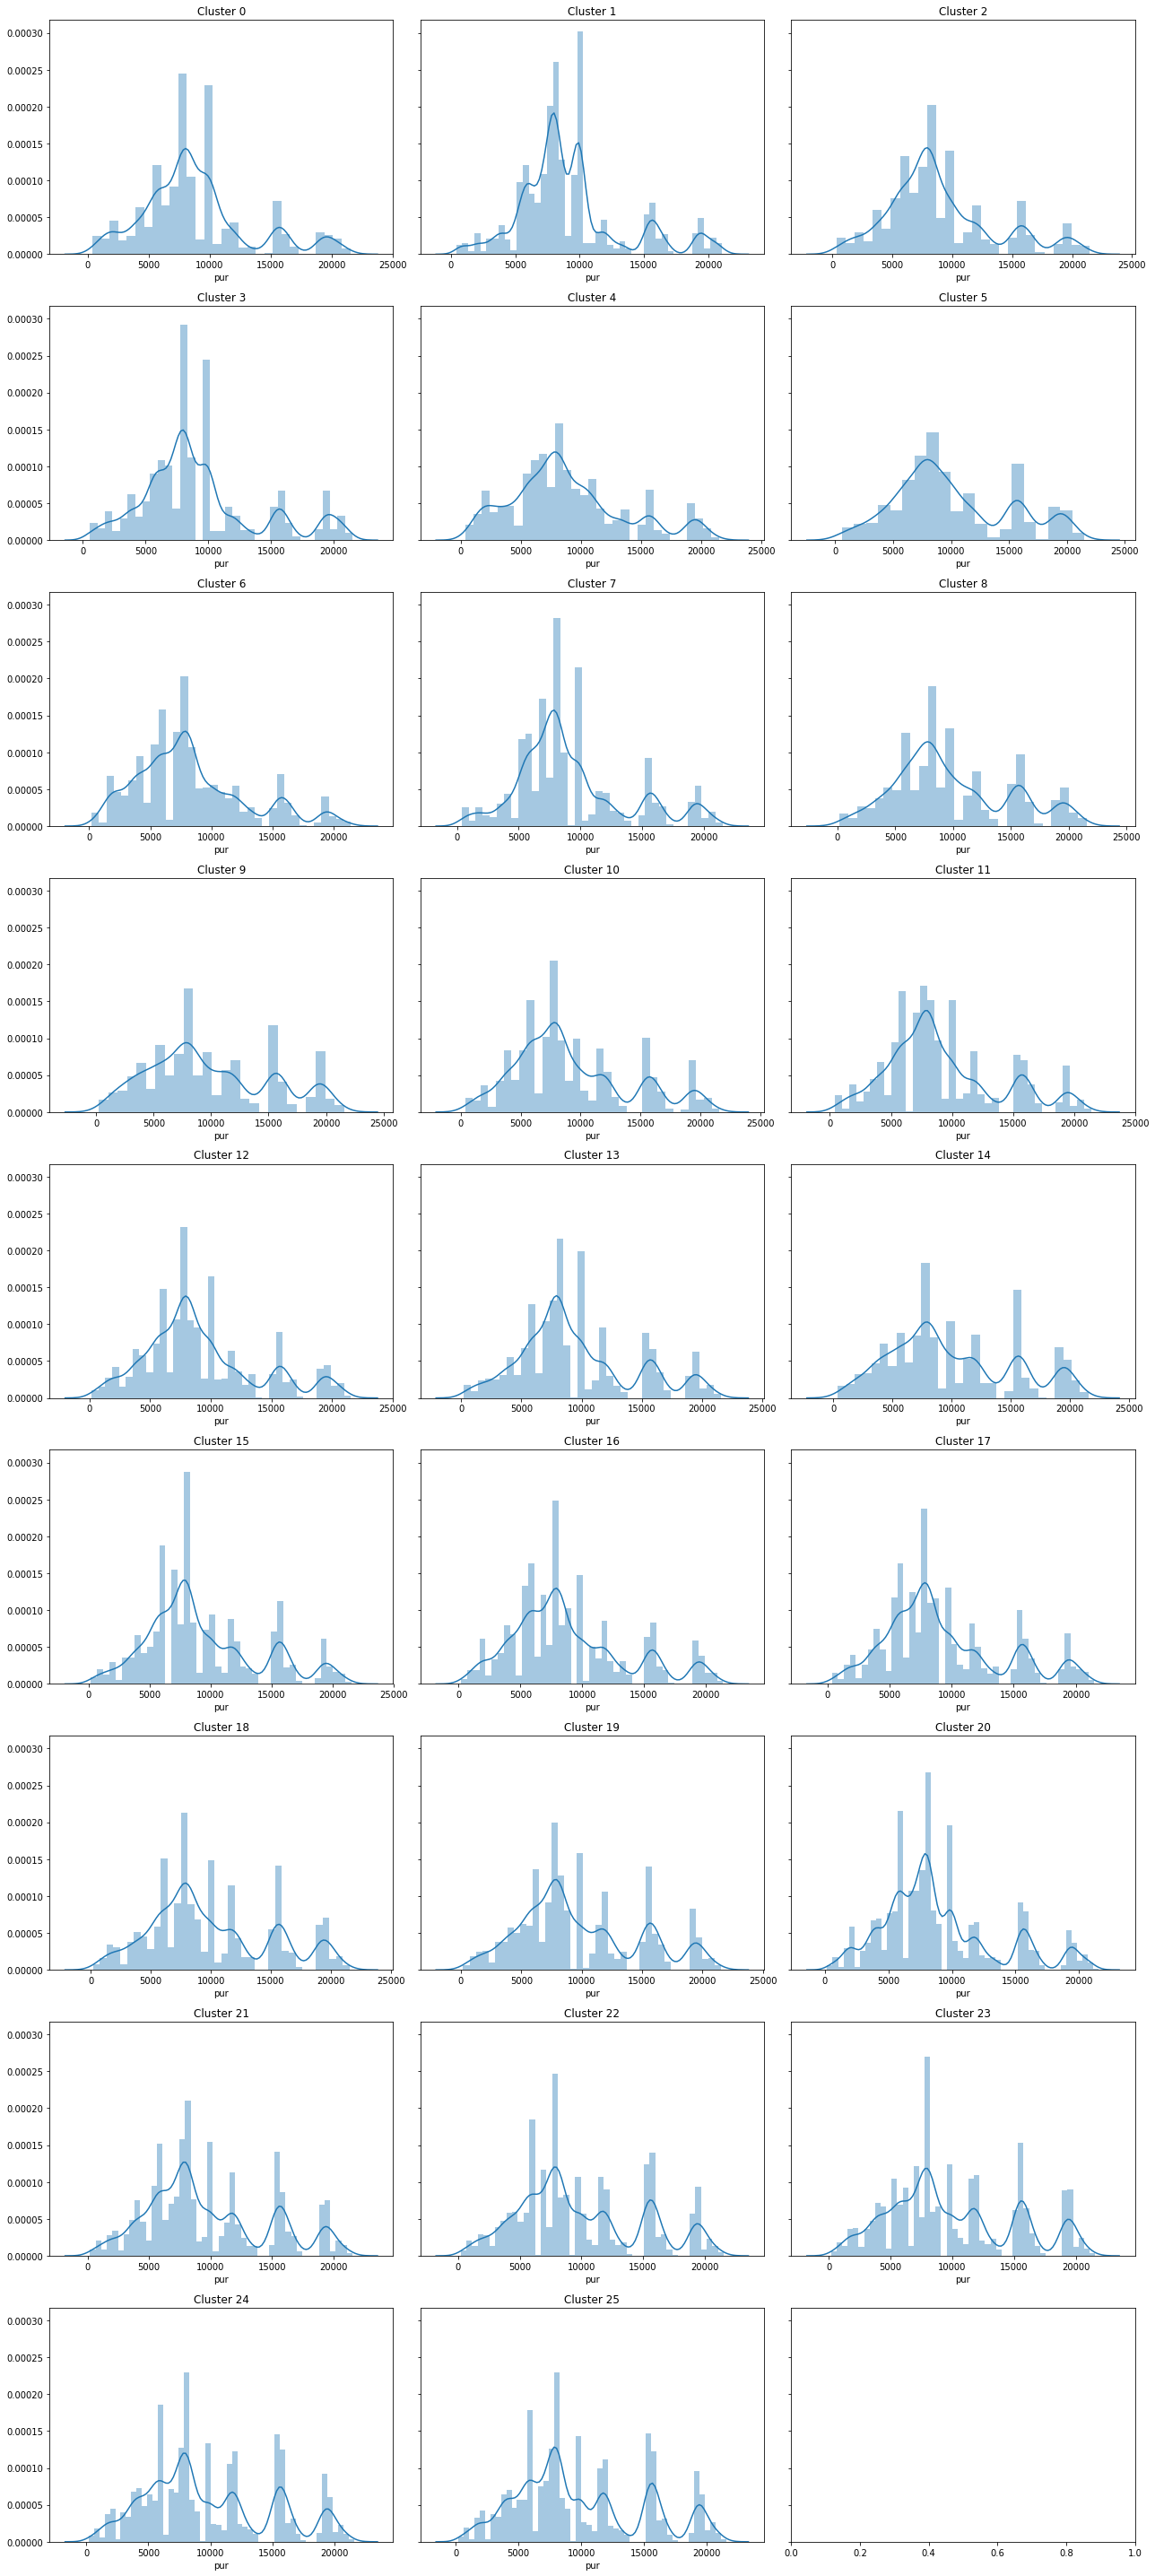

In [8]:
fig, axs = plt.subplots(len(custom_clusters)//3 + 1, 3, figsize = (18,40), sharey=True)
for i, cluster in enumerate(custom_clusters):
    axs[i//3, i%3].set_title("Cluster %d" % i)
    sns.distplot(cluster['pur'], ax = axs[i//3, i%3])
plt.tight_layout()

In [ ]:
# Creates dataset with one hot vectors except on age
one_hot_features = ['occ', 'city', 'p_cat_1', 'p_cat_2', 'p_cat_3']
for feature in one_hot_features:
    if feature in cols:
        ranges = pd.unique(pd.Series(trimmed_modeldf[feature]))
        ranges.sort()
        mapped = [feature + '_' + str(x) for x in range(len(ranges))]
        trimmed_modeldf[feature] = trimmed_modeldf[feature].map(dict(zip(ranges, mapped)))
        one_hot = pd.get_dummies(trimmed_modeldf[feature])
        trimmed_modeldf = trimmed_modeldf.drop(feature, axis = 1)
        trimmed_modeldf = trimmed_modeldf.join(one_hot)

label_features = ['gender', 'age', 'years_in_city']

for feature in label_features:
    ranges = pd.unique(pd.Series(df[feature]))
    ranges.sort()
    mapped = [x for x in range(len(ranges))]
    trimmed_modeldf[feature] = trimmed_modeldf[feature].map(dict(zip(ranges, mapped)))

In [9]:
# splits datasets based on demographics specified
cluster_splits = ['gender', 'age', 'married', 'city']

temp = [modeldf]
first = True
for split in cluster_splits:
    other_temp = []
    for other in temp:
        other_temp.append([other[other[split] == x] for x in range(min(other[split]), max(other[split]) + 1)])
    if first:
        temp = other_temp[0]
        first = False
    else:
        temp = []
        for other in other_temp:
            for some_other in other:
                if not some_other.empty:
                    temp.append(some_other)

custom_clusters = sorted(temp, key=len)

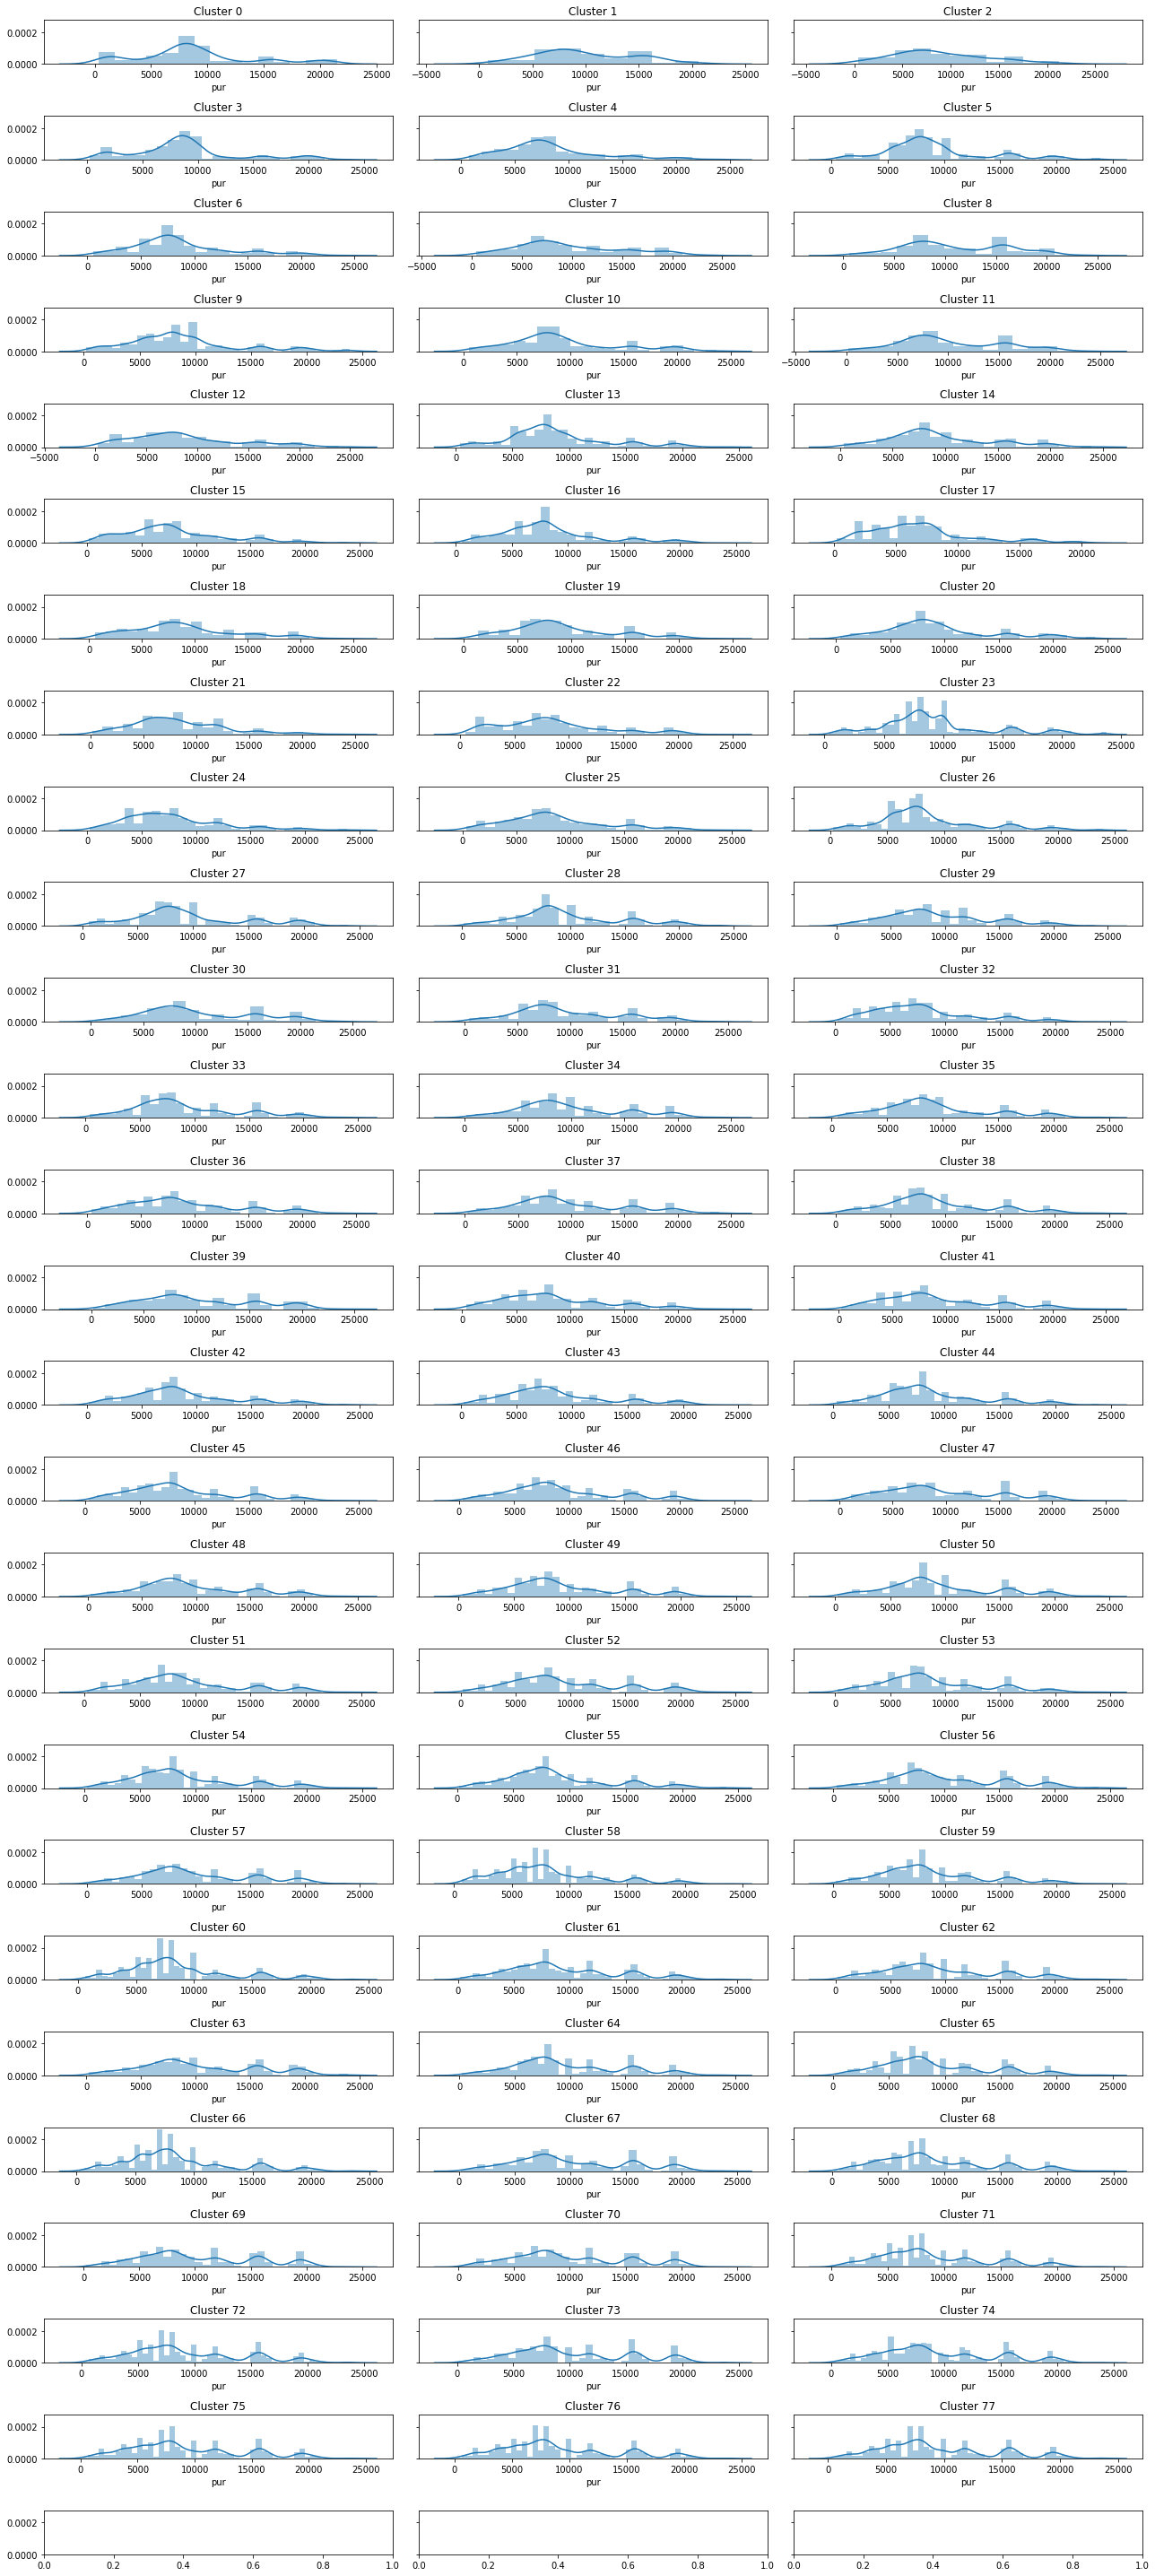

In [10]:
fig, axs = plt.subplots(len(custom_clusters)//3 + 1, 3, figsize = (18,40), sharey=True)
for i, cluster in enumerate(custom_clusters):
    axs[i//3, i%3].set_title("Cluster %d" % i)
    sns.distplot(cluster['pur'], ax = axs[i//3, i%3])
plt.tight_layout()

                                           Plots for gender                                           


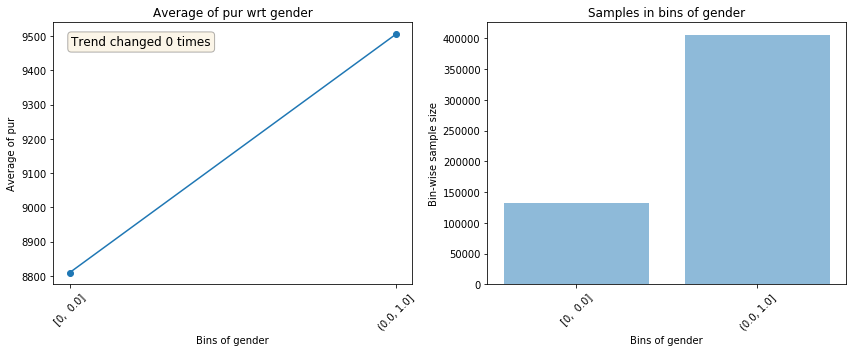

--------------------------------------------------------------------------------------------------------------


                                          Plots for married                                           


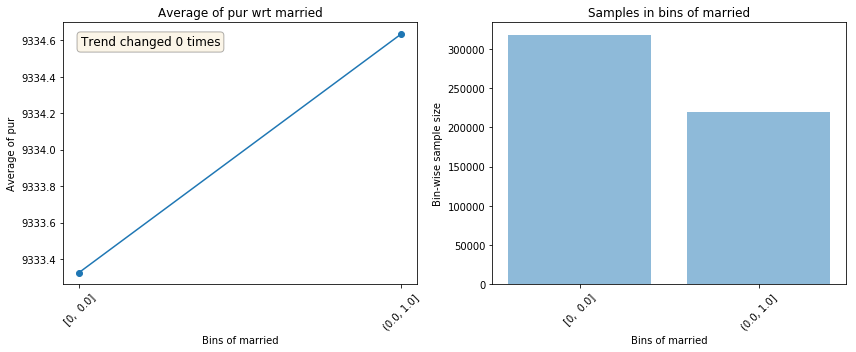

--------------------------------------------------------------------------------------------------------------


                                            Plots for age                                             


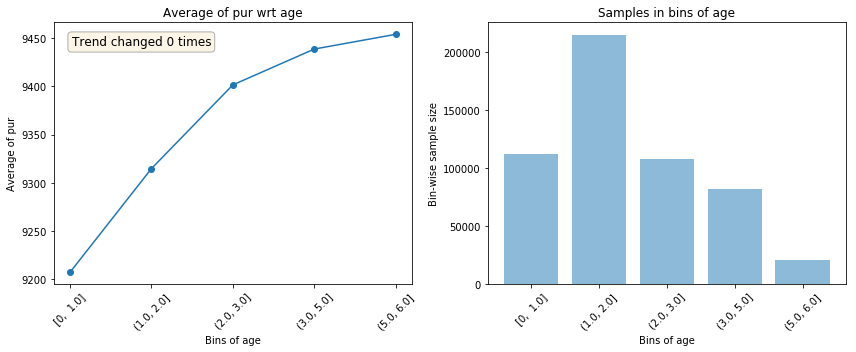

--------------------------------------------------------------------------------------------------------------


                                       Plots for years_in_city                                        


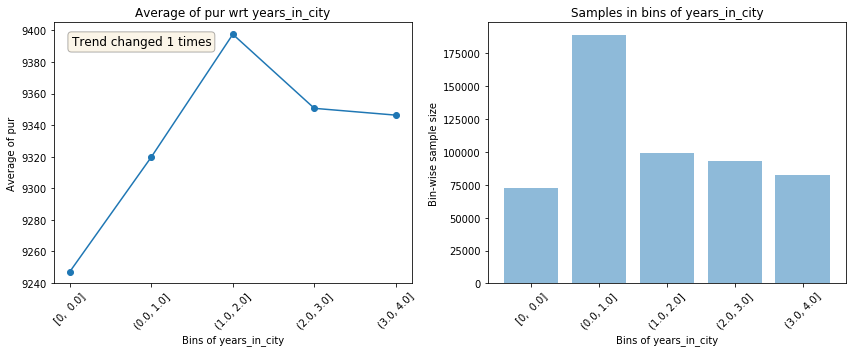

--------------------------------------------------------------------------------------------------------------


                                            Plots for occ                                             


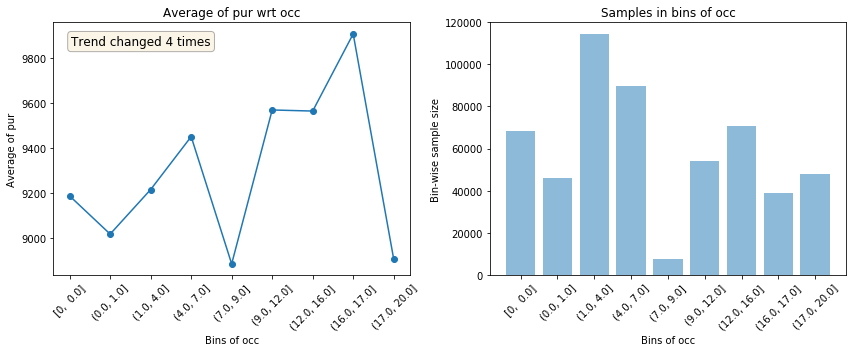

--------------------------------------------------------------------------------------------------------------


                                          Plots for p_cat_1                                           


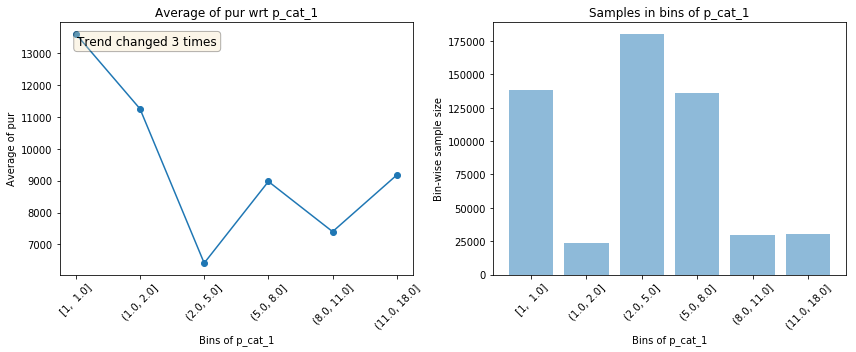

--------------------------------------------------------------------------------------------------------------


                                          Plots for p_cat_2                                           


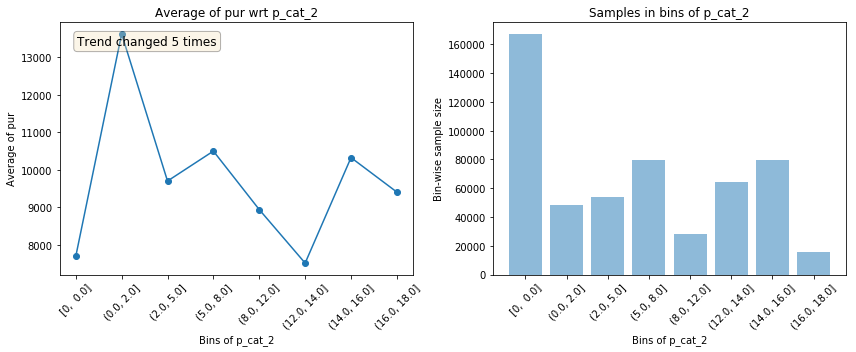

--------------------------------------------------------------------------------------------------------------


                                          Plots for p_cat_3                                           


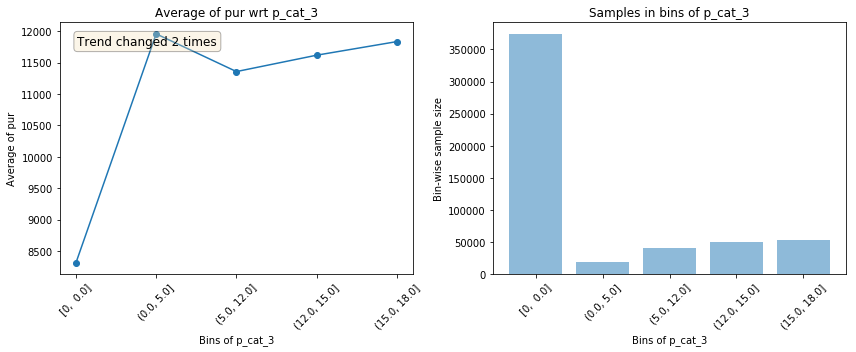

--------------------------------------------------------------------------------------------------------------




In [79]:
from featexp import get_univariate_plots

plot_types = ['gender', 'married', 'age', 'years_in_city', 'occ', 'p_cat_1', 'p_cat_2', 'p_cat_3']

get_univariate_plots(data=modeldf, target_col='pur', 
                     features_list= plot_types, bins=10)

In [78]:
# Train and testing data for model dataset
X_train, X_test, y_train, y_test = train_test_split(modeldf,y,test_size = 0.25, random_state=30)

y_train = np.array(y_train).T.reshape(1, -1)[0]
y_test = np.array(y_test).T.reshape(1, -1)[0]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from featexp import get_trend_stats
stats = get_trend_stats(data=X_train, target_col='pur', data_test=X_test)
stats

(403182, 10) (134395, 10) (403182,) (134395,)
Returning stats for all numeric features


,Feature,Trend_changes,Trend_changes_test,Trend_correlation
0,gender,0,0,1.000000
1,age,0,0,0.957181
2,occ,4,4,0.988995
3,city,0,0,0.999874
4,years_in_city,1,1,0.789143
5,married,0,0,1.000000
6,p_cat_1,3,3,0.999601
7,p_cat_2,5,5,0.999859
8,p_cat_3,2,2,0.999894


In [75]:
smaller_stats = stats[stats.Trend_correlation >= 0.9]
X_small = modeldf[smaller_stats.Feature]
X_small

,gender,age,years_in_city,married,occ_0,occ_1,occ_10,occ_11,occ_12,occ_14,...,p_cat_3_14,p_cat_3_15,p_cat_3_2,p_cat_3_3,p_cat_3_4,p_cat_3_5,p_cat_3_6,p_cat_3_7,p_cat_3_8,p_cat_3_9
0,0,0,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,6,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,4,2,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,1,4,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,4,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,2,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocessing Modeling

### Principle Componenet Analysis

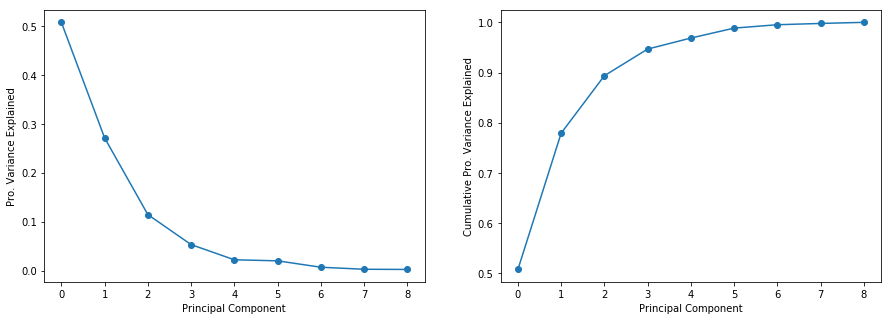

90% of variance explained by 4 principal components


,pc_0,pc_1,pc_2,pc_3
0,1.878853,-1.261544,-1.858658,0.286830
1,1.906045,-5.275688,-1.807473,-1.813906
2,1.805871,3.789598,5.530935,-0.621570
3,1.797812,7.159118,3.364029,0.491245
4,7.984743,1.679845,2.341381,-0.327052


In [82]:
# Generates principal component dataset

per_variance_captured = .90

pca = PCA()
if 'p_id' in X.columns:
    pca.fit(X.drop('p_id', axis = 1))
else:
    pca.fit(X)
plt.subplots(2,1, figsize=(15,5))
ax1 = plt.subplot(1,2,1)
plt.plot(pca.explained_variance_ratio_, '-o')
plt.xlabel("Principal Component")
plt.ylabel("Pro. Variance Explained")
ax1 = plt.subplot(1,2,2)
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Pro. Variance Explained")
plt.show()

N3 = np.where(np.cumsum(pca.explained_variance_ratio_)>=per_variance_captured)[0][0]+1
print('90% of variance explained by {} principal components' .format(N3))

n_components = N3 # based on 90% variance explained  
pca = PCA(n_components = n_components)
if 'p_id' in X.columns:
    principalComponents = pca.fit_transform(X.drop('p_id', axis = 1))
else:
    principalComponents = pca.fit_transform(X)
X_pca = pd.DataFrame(data = principalComponents, 
                           columns = ['pc_' + str(x) for x in range(pca.n_components_)])
if 'p_id' in X.columns:
    X_pca = X_pca.join(X['p_id'])
X_pca.head()

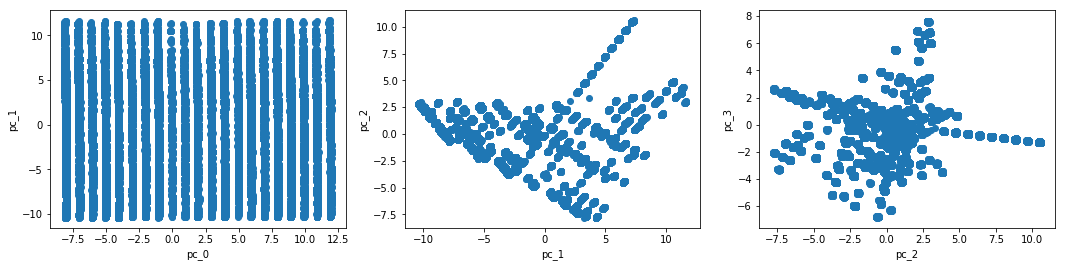

In [83]:
fig, axs = plt.subplots(1, 3, figsize = (18,4))
ax1 = plt.subplot(1,3,1)
plt.scatter(X_pca['pc_0'], X_pca['pc_1'])
plt.xlabel('pc_0')
plt.ylabel('pc_1')
ax2 = plt.subplot(1,3,2)
plt.scatter(X_pca['pc_1'], X_pca['pc_2'])
plt.xlabel('pc_1')
plt.ylabel('pc_2')
ax3 = plt.subplot(1,3,3)
plt.scatter(X_pca['pc_2'], X_pca['pc_3'])
plt.xlabel('pc_2')
plt.ylabel('pc_3')
plt.show()

### K-means Clustering

In [43]:
# Generates k-means cluster datasets

kmeansdf = X[demo_cols]

kmeans = KMeans(n_clusters = 3).fit(kmeansdf) # testing shows that 2-3 clussters works the best
cluster_nums = kmeans.predict(kmeansdf)

# Single dataset for clusters
X_cluster = pd.DataFrame(cluster_nums, columns = ['cluster_num'])
X_cluster = X_cluster.join(X)
# Seperate datasets based on clusters
temp = X_cluster.join(y)
X_clusters = [temp[temp['cluster_num'] == x] for x in range(max(temp['cluster_num']) + 1)]
X_cluster.head()

,cluster_num,gender,age,years_in_city,married,occ_0,occ_1,occ_10,occ_11,occ_12,...,p_cat_3_14,p_cat_3_15,p_cat_3_2,p_cat_3_3,p_cat_3_4,p_cat_3_5,p_cat_3_6,p_cat_3_7,p_cat_3_8,p_cat_3_9
0,2,0,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,6,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


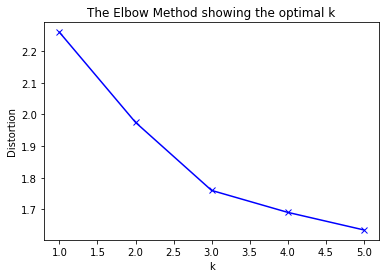

In [45]:
distortions = []

K = range(1,6)
for k in K:
    kmean = KMeans(n_clusters=k).fit(kmeansdf)
    distortions.append(sum(np.min(cdist(kmeansdf, kmean.cluster_centers_, 'euclidean'), axis=1)) / kmeansdf.shape[0])

# Plot the elbow 3 - 4 looks like the best choice
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


#### Clustering using PCA Dataset

In [96]:
# Generates k-means cluster using PCA datasets

pca_kmeansdf = X_pca

pca_kmeans = KMeans(n_clusters = 5).fit(pca_kmeansdf) # testing shows that 5 - 6 clusters works best
pca_cluster_nums = pca_kmeans.predict(pca_kmeansdf)
# Single dataset for clusters
X_pca_cluster = pd.DataFrame(pca_cluster_nums, columns = ['cluster_num'])
X_pca_cluster = X_pca_cluster.join(X.drop(demo_cols, axis = 1))
# Seperate datasets for clusters
X_pca_clusters = [X_pca_cluster[X_pca_cluster['cluster_num'] == x] for x in range(max(X_pca_cluster['cluster_num']) + 1)]
X_pca_cluster.head()

,cluster_num,p_cat_1_0,p_cat_1_1,p_cat_1_10,p_cat_1_11,p_cat_1_12,p_cat_1_13,p_cat_1_14,p_cat_1_15,p_cat_1_16,...,p_cat_3_14,p_cat_3_15,p_cat_3_2,p_cat_3_3,p_cat_3_4,p_cat_3_5,p_cat_3_6,p_cat_3_7,p_cat_3_8,p_cat_3_9
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


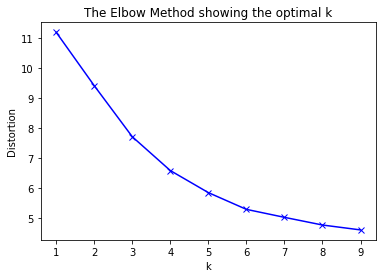

In [35]:
pca_distortions = []

K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k).fit(pca_kmeansdf)
    pca_distortions.append(sum(np.min(cdist(pca_kmeansdf, kmean.cluster_centers_, 'euclidean'), axis=1)) / pca_kmeansdf.shape[0])

# Plot the elbow 3 looks like the best choice
plt.plot(K, pca_distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


# Predictive Modeling 

### Creating Modeling Datasets

In [11]:
# Train and testing data for model dataset
X = modeldf.drop(predictor, axis = 1)
y = modeldf[predictor]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=30)

y_train = np.array(y_train).T.reshape(1, -1)[0]
y_test = np.array(y_test).T.reshape(1, -1)[0]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(403182, 90) (134395, 90) (403182,) (134395,)


In [6]:
X_s = StandardScaler().fit_transform(X)

X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s,y,test_size = 0.25, random_state=30)

y_s_train = np.array(y_s_train).T.reshape(1, -1)[0]
y_s_test = np.array(y_s_test).T.reshape(1, -1)[0]

print(X_s_train.shape, X_s_test.shape, y_s_train.shape, y_s_test.shape)

C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(403182, 80) (134395, 80) (403182,) (134395,)


In [17]:
# Train and testing data for PCA dataset
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca,y,test_size = 0.25, random_state=30)

y_pca_train = np.array(y_pca_train).T.reshape(1, -1)[0]
y_pca_test = np.array(y_pca_test).T.reshape(1, -1)[0]

print(X_pca_train.shape, X_pca_test.shape, y_pca_train.shape, y_pca_test.shape)

(403182, 4) (134395, 4) (403182,) (134395,)


In [18]:
X_s_pca = StandardScaler().fit_transform(X_pca)

X_s_pca_train, X_s_pca_test, y_s_pca_train, y_s_pca_test = train_test_split(X_s_pca,y,test_size = 0.25, random_state=30)

y_s_train = np.array(y_s_train).T.reshape(1, -1)[0]
y_s_test = np.array(y_s_test).T.reshape(1, -1)[0]

print(X_s_pca_train.shape, X_s_pca_test.shape, y_s_train.shape, y_s_test.shape)

(403182, 4) (134395, 4) (403182,) (134395,)


In [24]:
# Train and testing data for cluster dataset
X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_cluster,y,test_size = 0.25, random_state=30)

y_cl_train = np.array(y_cl_train).T.reshape(1, -1)[0]
y_cl_test = np.array(y_cl_test).T.reshape(1, -1)[0]

print(X_cl_train.shape, X_cl_test.shape, y_cl_train.shape, y_cl_test.shape)

(403182, 81) (134395, 81) (403182,) (134395,)


In [25]:
# Train and testing data for cluster dataset
X_s_cl = StandardScaler().fit_transform(X_cluster)

X_s_cl_train, X_s_cl_test, y_s_cl_train, y_s_cl_test = train_test_split(X_s_cl,y,test_size = 0.25, random_state=30)

y_s_cl_train = np.array(y_s_cl_train).T.reshape(1, -1)[0]
y_s_cl_test = np.array(y_s_cl_test).T.reshape(1, -1)[0]

print(X_s_cl_train.shape, X_s_cl_test.shape, y_s_cl_train.shape, y_s_cl_test.shape)

C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(403182, 81) (134395, 81) (403182,) (134395,)


In [103]:
# Train and testing data for PCA cluster dataset
X_pca_cl_train, X_pca_cl_test, y_pca_cl_train, y_pca_cl_test = train_test_split(X_pca_cluster,y,test_size = 0.25, random_state=30)

y_pca_cl_train = np.array(y_pca_cl_train).T.reshape(1, -1)[0]
y_pca_cl_test = np.array(y_pca_cl_test).T.reshape(1, -1)[0]

print(X_pca_cl_train.shape, X_pca_cl_test.shape, y_pca_cl_train.shape, y_pca_cl_test.shape)

(403182, 53) (134395, 53) (403182,) (134395,)


In [104]:
# Train and testing data for PCA cluster dataset
X_s_pca_cl = StandardScaler().fit_transform(X_pca_cluster)
X_s_pca_cl_train, X_s_pca_cl_test, y_s_pca_cl_train, y_s_pca_cl_test = train_test_split(X_s_pca_cl,y,test_size = 0.25, random_state=30)

y_s_pca_cl_train = np.array(y_s_pca_cl_train).T.reshape(1, -1)[0]
y_s_pca_cl_test = np.array(y_s_pca_cl_test).T.reshape(1, -1)[0]

print(X_s_pca_cl_train.shape, X_s_pca_cl_test.shape, y_s_pca_cl_train.shape, y_s_pca_cl_test.shape)

(403182, 53) (134395, 53) (403182,) (134395,)


In [33]:
# Train and testing data for sperate cluster datasets

X_cl_trains = []
X_cl_tests = [] 
y_cl_trains = []
y_cl_tests = []

for i, clusterdf in enumerate(X_clusters):
    X_frame = clusterdf.drop(predictor, axis = 1)
    y_frame = clusterdf[predictor]
    X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_frame, y_frame, test_size = 0.25, random_state=30)
    y_cl_train = np.array(y_cl_train).T.reshape(1, -1)[0]
    y_cl_test = np.array(y_cl_test).T.reshape(1, -1)[0]
    X_cl_trains.append(X_cl_train)
    X_cl_tests.append(X_cl_test)
    y_cl_trains.append(y_cl_train)
    y_cl_tests.append(y_cl_test)
    print(X_cl_trains[i].shape, X_cl_tests[i].shape, y_cl_trains[i].shape, y_cl_tests[i].shape)

(216855, 81) (72285, 81) (216855,) (72285,)
(114307, 81) (38103, 81) (114307,) (38103,)
(72020, 81) (24007, 81) (72020,) (24007,)


In [19]:
# Train and testing data for sperate PCA cluster datasets
X_pca_cl_trains = []
X_pca_cl_tests = [] 
y_pca_cl_trains = []
y_pca_cl_tests = []

for i, X_pca_cluster in enumerate(pca_clusterdfs):
    X_frame = X_pca_cluster.drop(predictor, axis = 1)
    y_frame = X_pca_cluster[predictor]
    X_pca_cl_train, X_pca_cl_test, y_pca_cl_train, y_pca_cl_test = train_test_split(X_frame, y_frame, test_size = 0.25, random_state=30)
    y_pca_cl_train = np.array(y_pca_cl_train).T.reshape(1, -1)[0]
    y_pca_cl_test = np.array(y_pca_cl_test).T.reshape(1, -1)[0]
    
    X_pca_cl_trains.append(X_pca_cl_train)
    X_pca_cl_tests.append(X_pca_cl_test)
    y_pca_cl_trains.append(y_pca_cl_train)
    y_pca_cl_tests.append(y_pca_cl_test)
    print(X_pca_cl_trains[i].shape, X_pca_cl_tests[i].shape, y_pca_cl_trains[i].shape, y_pca_cl_tests[i].shape)

(57804, 53) (19268, 53) (57804,) (19268,)
(54177, 53) (18059, 53) (54177,) (18059,)
(109042, 53) (36348, 53) (109042,) (36348,)
(23108, 53) (7703, 53) (23108,) (7703,)
(159051, 53) (53017, 53) (159051,) (53017,)


### Linear Regression

In [13]:
reg = LinearRegression(fit_intercept = False).fit(X_train, y_train)
print(np.sqrt(mean_squared_error(reg.predict(X_test), y_test)))

2990.7809717706577


In [83]:
reg = LinearRegression().fit(X_s_train, y_s_train)
print(mean_absolute_error(reg.predict(X_s_test), y_s_test))

3546.3614347581943


In [24]:
reg = LinearRegression().fit(X_pca_train, y_pca_train)
print(np.sqrt(mean_squared_error(reg.predict(X_pca_test), y_pca_test)))

4717.370115488769


In [25]:
reg = LinearRegression().fit(X_s_pca_train, y_s_pca_train)
print(np.sqrt(mean_squared_error(reg.predict(X_s_pca_test), y_s_pca_test)))

4717.370115488769


In [26]:
reg = LinearRegression(fit_intercept = False).fit(X_cl_train, y_cl_train)
print(np.sqrt(mean_squared_error(reg.predict(X_cl_test), y_cl_test)))

2990.990050436748


In [27]:
reg = LinearRegression().fit(X_s_cl_train, y_s_cl_train)
print(np.sqrt(mean_squared_error(reg.predict(X_s_cl_test), y_s_cl_test)))

2990.951433630634


In [112]:
reg = LinearRegression(fit_intercept = False).fit(X_pca_cl_train, y_pca_cl_train)
print(np.sqrt(mean_squared_error(reg.predict(X_pca_cl_test), y_pca_cl_test)))

3002.865942314471


In [113]:
reg = LinearRegression().fit(X_s_pca_cl_train, y_s_pca_cl_train)
print(np.sqrt(mean_squared_error(reg.predict(X_s_pca_cl_test), y_s_pca_cl_test)))

3002.8659468585497


In [25]:
for X_cl_train, X_cl_test, y_cl_train, y_cl_test in zip(X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests):
    reg = LinearRegression().fit(X_cl_train, y_cl_train)
    print(reg.score(X_cl_test, y_cl_test))

NameError: name 'X_cl_trains' is not defined

In [56]:
for X_pca_cl_train, X_pca_cl_test, y_pca_cl_train, y_pca_cl_test in zip(X_pca_cl_trains, X_pca_cl_tests, y_pca_cl_trains, y_pca_cl_tests):
    reg = LinearRegression().fit(X_pca_cl_train, y_pca_cl_train)
    print(reg.score(X_pca_cl_test, y_pca_cl_test))

0.6850506651739179
0.6063195406919012
0.6127104609849221
0.6409470201025337
0.6814269763186069
0.6309024620049404


### MLP Regression

Iteration 1, loss = 7280514.96011494
Iteration 2, loss = 4363380.17914308
Iteration 3, loss = 4366563.63524259
Iteration 4, loss = 4379597.10894146
Iteration 5, loss = 4387364.10399726
Iteration 6, loss = 4375674.61004119
Iteration 7, loss = 4399277.79222160
Iteration 8, loss = 4412559.27983344
Iteration 9, loss = 4375846.09384983
Iteration 10, loss = 4413384.97069870
Iteration 11, loss = 4400008.12689778
Iteration 12, loss = 4411880.93470528
Iteration 13, loss = 4400028.20527313
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
2237.660091776841


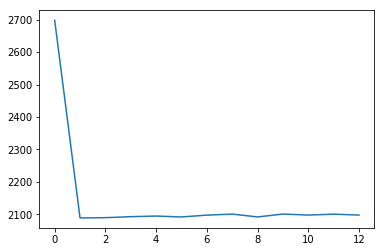

In [139]:
from sklearn.metrics import mean_absolute_error
h_layer_sizes = (25, 1)

mlp = MLPRegressor(activation = 'identity',
                   hidden_layer_sizes = h_layer_sizes,
                   solver = 'adam',
                   learning_rate = 'constant',
                   random_state = 42,
                   batch_size = 3000,
                   verbose = True,
                   learning_rate_init = 1).fit(X_train, y_train)
plt.plot(np.sqrt(mlp.loss_curve_))
print(mean_absolute_error(mlp.predict(X_test), y_test))
plt.show()

Iteration 1, loss = 8260527.21354121
Iteration 2, loss = 4529888.26219580
Iteration 3, loss = 4532787.35190945
Iteration 4, loss = 4516597.25277764
Iteration 5, loss = 4516999.91354414
Iteration 6, loss = 4477131.55050638
Iteration 7, loss = 4513177.62811235
Iteration 8, loss = 4506899.73786892
Iteration 9, loss = 4462772.78650856
Iteration 10, loss = 4535572.31661798
Iteration 11, loss = 4474467.27678892
Iteration 12, loss = 4490634.99534159
Iteration 13, loss = 4477094.89878225
Iteration 14, loss = 4479140.71003890
Iteration 15, loss = 4491200.18401754
Iteration 16, loss = 4481297.96097195
Iteration 17, loss = 4490316.43065259
Iteration 18, loss = 4469920.90481368
Iteration 19, loss = 4480126.23873126
Iteration 20, loss = 4507430.88201407
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
2314.3011041607438


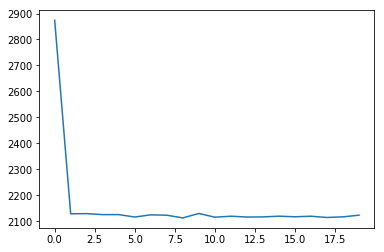

In [138]:
from sklearn.metrics import mean_absolute_error

h_layer_size = (25, 1)
mlp = MLPRegressor(activation = 'identity',
                   hidden_layer_sizes = h_layer_size,
                   solver = 'adam',
                   learning_rate = 'constant',
                   random_state = 42,
                   batch_size = 3000,
                   verbose = True,
                   learning_rate_init = 1).fit(X_s_train, y_train)
plt.plot(np.sqrt(mlp.loss_curve_))
print(mean_absolute_error(mlp.predict(X_s_test), y_test))
plt.show()

Iteration 1, loss = 12080454.93835459
Iteration 2, loss = 11233639.86748819
Iteration 3, loss = 11220947.19977183
Iteration 4, loss = 11224928.09851252
Iteration 5, loss = 11215604.17703501
Iteration 6, loss = 11229936.48500379
Iteration 7, loss = 11216493.02161484
Iteration 8, loss = 11226878.14496183
Iteration 9, loss = 11206663.19052359
Iteration 10, loss = 11218368.94539876
Iteration 11, loss = 11215545.81536576
Iteration 12, loss = 11205612.20582505
Iteration 13, loss = 11199558.46004179
Iteration 14, loss = 11187412.05943600
Iteration 15, loss = 11177243.06302341
Iteration 16, loss = 11168247.47330656
Iteration 17, loss = 11169566.31994211
Iteration 18, loss = 11184292.90258543
Iteration 19, loss = 11173338.64027741
Iteration 20, loss = 11171579.49989990
Iteration 21, loss = 11170175.50530011
Iteration 22, loss = 11176408.41011662
Iteration 23, loss = 11181459.58007470
Iteration 24, loss = 11160159.01618602
Iteration 25, loss = 11164389.04328168
Iteration 26, loss = 11182365.2589

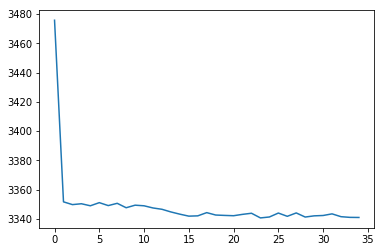

In [99]:
h_layer_sizes = (25)

mlp = MLPRegressor(activation = 'identity',
                   hidden_layer_sizes = h_layer_sizes,
                   solver = 'adam',
                   learning_rate = 'constant',
                   random_state = 42,
                   batch_size = 500,
                   verbose = True,
                   learning_rate_init = 1).fit(X_pca_train, y_pca_train)
plt.plot(np.sqrt(mlp.loss_curve_))
print(np.sqrt(mean_squared_error(mlp.predict(X_pca_test), y_pca_test)))
plt.show()

Iteration 1, loss = 7879011.65870016
Iteration 2, loss = 6926981.03939432
Iteration 3, loss = 6115056.21992269
Iteration 4, loss = 5933664.75827803
Iteration 5, loss = 5853242.81083211
Iteration 6, loss = 5801922.41398776
Iteration 7, loss = 5756930.94658499
Iteration 8, loss = 5662902.64851443
Iteration 9, loss = 5674175.48206832
Iteration 10, loss = 5593885.63586897
Iteration 11, loss = 5537703.54809406
Iteration 12, loss = 5450455.09005174
Iteration 13, loss = 5406371.73666390
Iteration 14, loss = 5353535.55672914
Iteration 15, loss = 5341665.68285759
Iteration 16, loss = 5269335.15338790
Iteration 17, loss = 5294798.81017632
Iteration 18, loss = 5263422.27597467
Iteration 19, loss = 5246101.01088298
Iteration 20, loss = 5216802.96905086
Iteration 21, loss = 5206901.44148568
Iteration 22, loss = 5204203.02947131
Iteration 23, loss = 5182903.77563832
Iteration 24, loss = 5217048.71577033
Iteration 25, loss = 5174191.27747607
Iteration 26, loss = 5217479.30504668
Iteration 27, loss = 

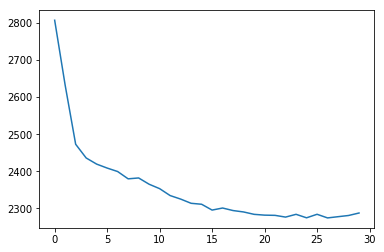

In [89]:
h_layer_sizes = [(25,25)]

for hidden_layer_size in h_layer_sizes:
    mlp = MLPRegressor(activation = 'relu',
                       hidden_layer_sizes = hidden_layer_size,
                       solver = 'adam',
                       learning_rate = 'constant',
                       random_state = 42,
                       batch_size = 500,
                       verbose = True,
                       learning_rate_init = .5).fit(X_s_pca_train, y_pca_train)
    plt.plot(np.sqrt(mlp.loss_curve_))
    print(np.sqrt(mean_squared_error(mlp.predict(X_s_pca_test), y_pca_test)))
plt.show()

In [87]:
h_layer_sizes = (25, 1)

mlp = MLPRegressor(activation = 'relu',
                   hidden_layer_sizes = h_layer_sizes,
                   solver = 'adam',
                   learning_rate = 'constant',
                   random_state = 42,
                   batch_size = 500,
                   verbose = True,
                   learning_rate_init = 1).fit(X_cl_train, y_cl_train)
plt.plot(np.sqrt(mlp.loss_curve_))
print(np.sqrt(mean_squared_error(mlp.predict(X_cl_test), y_cl_test)))
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Iteration 1, loss = 5171596.90741262
Iteration 2, loss = 4619340.66478927
Iteration 3, loss = 4543378.67609275
Iteration 4, loss = 4503557.76497702
Iteration 5, loss = 4497461.64769586
Iteration 6, loss = 4496502.51915526
Iteration 7, loss = 4477740.98890286
Iteration 8, loss = 4474724.22695738
Iteration 9, loss = 4487385.97542105
Iteration 10, loss = 4470231.74236878
Iteration 11, loss = 4470958.24716715
Iteration 12, loss = 4468888.85351874
Iteration 13, loss = 4465249.79273085
Iteration 14, loss = 4468104.42733806
Iteration 15, loss = 4464050.12131728
Iteration 16, loss = 4462135.30451666
Iteration 17, loss = 4452892.58880988
Iteration 18, loss = 4455224.16455744
Iteration 19, loss = 4457313.62289624
Iteration 20, loss = 4467321.09225450
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
3052.2427824545807


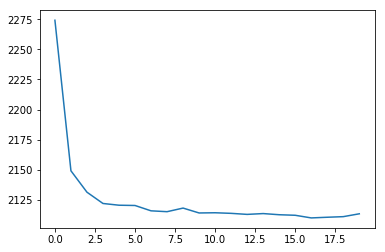

In [45]:
h_layer_sizes = [(25,)]

for hidden_layer_size in h_layer_sizes:
    mlp = MLPRegressor(activation = 'relu',
                       hidden_layer_sizes = hidden_layer_size,
                       solver = 'adam',
                       learning_rate = 'constant',
                       random_state = 42,
                       batch_size = 500,
                       verbose = True,
                       learning_rate_init = 1).fit(X_s_cl_train, y_s_cl_train)
    plt.plot(np.sqrt(mlp.loss_curve_))
    print(np.sqrt(mean_squared_error(mlp.predict(X_s_cl_test), y_s_cl_test)))
plt.show()

Iteration 1, loss = 5273006.76942865
Iteration 2, loss = 4572738.62255737
Iteration 3, loss = 4587688.13006266
Iteration 4, loss = 4585091.63151366
Iteration 5, loss = 4575602.94273841
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
3009.463613105503


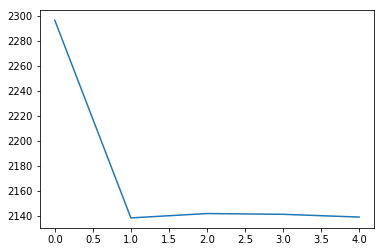

In [46]:
h_layer_sizes = [(25,)]

for hidden_layer_size in h_layer_sizes:
    mlp = MLPRegressor(activation = 'relu',
                       hidden_layer_sizes = hidden_layer_size,
                       solver = 'adam',
                       learning_rate = 'constant',
                       random_state = 42,
                       batch_size = 500,
                       verbose = True,
                       learning_rate_init = 1).fit(X_pca_cl_train, y_pca_cl_train)
    plt.plot(np.sqrt(mlp.loss_curve_))
    print(np.sqrt(mean_squared_error(mlp.predict(X_pca_cl_test), y_pca_cl_test)))
plt.show()

Iteration 1, loss = 5525623.42326252
Iteration 2, loss = 4456753.71257863
Iteration 3, loss = 4452825.69567264
Iteration 4, loss = 4442298.27398869
Iteration 5, loss = 4440167.87329089
Iteration 6, loss = 4435601.06013049
Iteration 7, loss = 4435483.39829361
Iteration 8, loss = 4421325.37357364
Iteration 9, loss = 4418080.68874026
Iteration 10, loss = 4415580.38324485
Iteration 11, loss = 4418951.88809651
Iteration 12, loss = 4424382.67362448
Iteration 13, loss = 4410049.46776348
Iteration 14, loss = 4411137.89392268
Iteration 15, loss = 4401909.31174041
Iteration 16, loss = 4406927.10324921
Iteration 17, loss = 4400792.51398992
Iteration 18, loss = 4404603.67778617
Iteration 19, loss = 4400597.46667934
Iteration 20, loss = 4405392.27784419
Iteration 21, loss = 4396556.25144443
Iteration 22, loss = 4398103.50562894
Iteration 23, loss = 4391735.11267324
Iteration 24, loss = 4389567.88561831
Iteration 25, loss = 4392126.36149131
Iteration 26, loss = 4387804.16550874
Iteration 27, loss = 

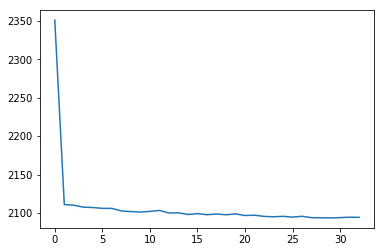

In [87]:
h_layer_sizes = [(25,25,)]

for hidden_layer_size in h_layer_sizes:
    mlp = MLPRegressor(activation = 'relu',
                       hidden_layer_sizes = hidden_layer_size,
                       solver = 'adam',
                       learning_rate = 'constant',
                       random_state = 42,
                       batch_size = 500,
                       verbose = True,
                       learning_rate_init = .1).fit(X_s_pca_cl_train, y_s_pca_cl_train)
    plt.plot(np.sqrt(mlp.loss_curve_))
    print(np.sqrt(mean_squared_error(mlp.predict(X_s_pca_cl_test), y_s_pca_cl_test)))
plt.show()

Iteration 1, loss = 5031931.98218550
Iteration 2, loss = 4805389.84562516
Iteration 3, loss = 4672902.63149418
Iteration 4, loss = 4635979.70817687
Iteration 5, loss = 4622627.06888765
Iteration 6, loss = 4617287.65499477
Iteration 7, loss = 4625649.27178124
Iteration 8, loss = 4623503.99016108
Iteration 9, loss = 4619810.00859185
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.6343610965537534


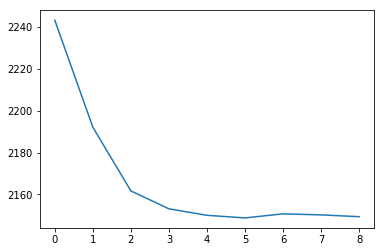

Iteration 1, loss = 5074909.58810940
Iteration 2, loss = 4825121.45031226
Iteration 3, loss = 4758552.98936046
Iteration 4, loss = 4663679.86834784
Iteration 5, loss = 4608012.13141195
Iteration 6, loss = 4593814.47577014
Iteration 7, loss = 4579430.70166494
Iteration 8, loss = 4570406.78263181
Iteration 9, loss = 4574202.11379459
Iteration 10, loss = 4563770.56076009
Iteration 11, loss = 4564682.63440843
Iteration 12, loss = 4570430.21056371
Iteration 13, loss = 4568805.16373016
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.6227783180183787


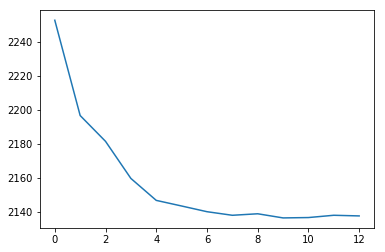

Iteration 1, loss = 4564110.24316007
Iteration 2, loss = 4133816.80296324
Iteration 3, loss = 4068426.85612745
Iteration 4, loss = 4008376.73760200
Iteration 5, loss = 3971562.17484785
Iteration 6, loss = 3936607.69235342
Iteration 7, loss = 3935323.79088017
Iteration 8, loss = 3904654.90201336
Iteration 9, loss = 3911683.48352318
Iteration 10, loss = 3887845.23830981
Iteration 11, loss = 3896163.11333023
Iteration 12, loss = 3887691.40764274
Iteration 13, loss = 3891211.86915232
Iteration 14, loss = 3895967.75324305
Iteration 15, loss = 3889918.75060819
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.6882216592835031


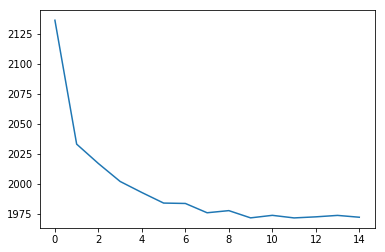

In [85]:
h_layer_sizes = [(25,)]

for X_cl_train, X_cl_test, y_cl_train, y_cl_test in zip(X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests):
    for hidden_layer_size in h_layer_sizes:
        mlp = MLPRegressor(activation = 'relu',
                           hidden_layer_sizes = hidden_layer_size,
                           solver = 'adam',
                           learning_rate = 'constant',
                           random_state = 42,
                           batch_size = 50,
                           verbose = True,
                           learning_rate_init = 1).fit(X_cl_train, y_cl_train)
        plt.plot(np.sqrt(mlp.loss_curve_))
        print(mlp.score(X_cl_test, y_cl_test))
    plt.show()

Iteration 1, loss = 5676578.18996316
Iteration 2, loss = 5146673.88610883
Iteration 3, loss = 5174562.73684525
Iteration 4, loss = 5145533.59767924
Iteration 5, loss = 5078969.02260955
Iteration 6, loss = 5043649.62707066
Iteration 7, loss = 4980999.28422228
Iteration 8, loss = 4941556.67684576
Iteration 9, loss = 4903417.59385557
Iteration 10, loss = 4901763.16199501
Iteration 11, loss = 4877213.51385711
Iteration 12, loss = 4869629.30581837
Iteration 13, loss = 4868440.20780967
Iteration 14, loss = 4848866.53418754
Iteration 15, loss = 4859670.11007423
Iteration 16, loss = 4865306.64262178
Iteration 17, loss = 4855540.73371934
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.6103977759559925


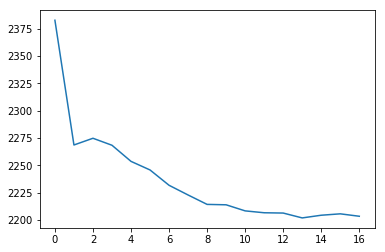

Iteration 1, loss = 4640135.79240818
Iteration 2, loss = 4122883.23720528
Iteration 3, loss = 4078585.33464669
Iteration 4, loss = 4060771.33305538
Iteration 5, loss = 4005082.71887869
Iteration 6, loss = 3998055.65356080
Iteration 7, loss = 3952817.38742121
Iteration 8, loss = 3900702.57469913
Iteration 9, loss = 3863423.83166638
Iteration 10, loss = 3878887.06883490
Iteration 11, loss = 3871266.76037391
Iteration 12, loss = 3849439.71765228
Iteration 13, loss = 3852860.11545807
Iteration 14, loss = 3852583.79575882
Iteration 15, loss = 3850756.91926341
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.6818516498659659


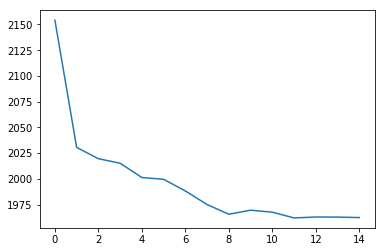

Iteration 1, loss = 5164818.07936433
Iteration 2, loss = 4848776.11593042
Iteration 3, loss = 4755198.39633658
Iteration 4, loss = 4686338.13225714
Iteration 5, loss = 4648115.08667470
Iteration 6, loss = 4641186.63672376
Iteration 7, loss = 4633166.57275823
Iteration 8, loss = 4627603.10697650
Iteration 9, loss = 4618636.93830822
Iteration 10, loss = 4619375.18666048
Iteration 11, loss = 4620631.23016675
Iteration 12, loss = 4619538.68157026
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.6293910916303948


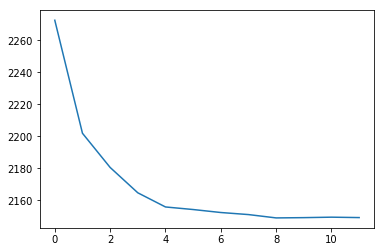

Iteration 1, loss = 5567818.15407649
Iteration 2, loss = 4211377.12787941
Iteration 3, loss = 4228256.63464044
Iteration 4, loss = 4165517.06473283
Iteration 5, loss = 4197611.08842192
Iteration 6, loss = 4188583.07964530
Iteration 7, loss = 4189725.05127124
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.675855282888679


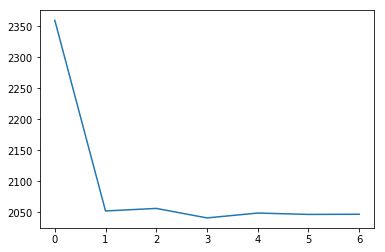

Iteration 1, loss = 4957590.62561390
Iteration 2, loss = 4700725.94479239
Iteration 3, loss = 4602270.25470520
Iteration 4, loss = 4568966.30297477
Iteration 5, loss = 4561211.23413664
Iteration 6, loss = 4541226.59965106
Iteration 7, loss = 4535916.28085877
Iteration 8, loss = 4536731.34322351
Iteration 9, loss = 4529320.83505099
Iteration 10, loss = 4528535.98478109
Iteration 11, loss = 4543795.01909747
Iteration 12, loss = 4529693.54825855
Iteration 13, loss = 4528550.87151186
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.6355799932068744


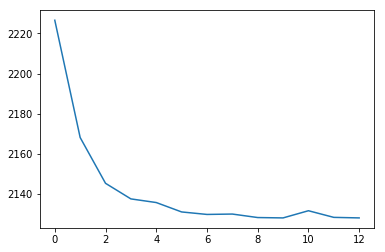

In [86]:
h_layer_sizes = [(25,)]

for X_pca_cl_train, X_pca_cl_test, y_pca_cl_train, y_pca_cl_test in zip(X_pca_cl_trains, X_pca_cl_tests, y_pca_cl_trains, y_pca_cl_tests):
    for hidden_layer_size in h_layer_sizes:
        mlp = MLPRegressor(activation = 'relu',
                           hidden_layer_sizes = hidden_layer_size,
                           solver = 'adam',
                           learning_rate = 'constant',
                           random_state = 42,
                           batch_size = 50,
                           verbose = True,
                           learning_rate_init = 1).fit(X_pca_cl_train, y_pca_cl_train)
        plt.plot(np.sqrt(mlp.loss_curve_))
        print(mlp.score(X_pca_cl_test, y_pca_cl_test))
    plt.show()

In [111]:
nodes = [10, 20, 40, 80, 160, 320, 640, 1280]
for node in nodes:
    rf = RandomForestRegressor(n_estimators = 8, max_leaf_nodes = node, random_state = 42, n_jobs = -1, verbose = 2).fit(X_s_train, y_s_train)
    print(mean_absolute_error(rf.predict(X_s_test), y_s_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 8
building tree 2 of 8
building tree 3 of 8
building tree 4 of 8
building tree 5 of 8
building tree 6 of 8building tree 7 of 8
building tree 8 of 8



[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    8.5s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    9.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


3166.3989416891736
building tree 1 of 8
building tree 2 of 8
building tree 3 of 8
building tree 4 of 8
building tree 5 of 8
building tree 6 of 8
building tree 7 of 8
building tree 8 of 8

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   11.2s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   11.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.



2981.6512501197753
building tree 1 of 8building tree 2 of 8
building tree 3 of 8
building tree 4 of 8
building tree 5 of 8
building tree 6 of 8building tree 7 of 8


building tree 8 of 8


[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   13.1s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


2949.1927175006563
building tree 1 of 8
building tree 2 of 8
building tree 3 of 8
building tree 4 of 8
building tree 5 of 8
building tree 6 of 8
building tree 7 of 8
building tree 8 of 8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   14.7s remaining:   24.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   15.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


2928.06094167493
building tree 1 of 8
building tree 2 of 8
building tree 3 of 8
building tree 4 of 8
building tree 5 of 8
building tree 6 of 8
building tree 7 of 8
building tree 8 of 8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   16.0s remaining:   26.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


2910.667196689888
building tree 1 of 8building tree 2 of 8
building tree 3 of 8
building tree 4 of 8building tree 5 of 8
building tree 6 of 8


building tree 7 of 8
building tree 8 of 8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   16.8s remaining:   28.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


2900.121161848026
building tree 1 of 8
building tree 2 of 8
building tree 3 of 8
building tree 4 of 8
building tree 5 of 8
building tree 6 of 8
building tree 7 of 8
building tree 8 of 8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   17.7s remaining:   29.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   19.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   19.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


2892.144825223494
building tree 1 of 8
building tree 2 of 8
building tree 3 of 8
building tree 4 of 8
building tree 5 of 8
building tree 6 of 8
building tree 7 of 8building tree 8 of 8



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   19.9s remaining:   33.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   22.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


2887.3728009805886


In [141]:
rf = RandomForestRegressor(n_estimators = 8, max_leaf_nodes = 640, random_state = 42, n_jobs = -1, verbose = 2).fit(X_s_train, y_s_train)
print(mean_absolute_error(rf.predict(X_s_test), y_s_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 8
building tree 2 of 8
building tree 3 of 8
building tree 4 of 8
building tree 5 of 8
building tree 6 of 8
building tree 7 of 8building tree 8 of 8



[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   18.7s remaining:   31.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   19.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s


2182.524892074164


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [154]:
from sklearn.ensemble import GradientBoostingRegressor

learning_rates = [1.5]
for learning_rate in learning_rates:
    gb = GradientBoostingRegressor(learning_rate = learning_rate, random_state = 42, max_leaf_nodes = 300, verbose = 2).fit(X_s_train, y_s_train)
    print(mean_absolute_error(gb.predict(X_s_test), y_s_test))

      Iter       Train Loss   Remaining Time 
         1    14903462.7803            6.80m
         2    12279254.4287            6.64m
         3    10831559.4734            6.36m
         4     9602867.1297            6.33m
         5     9238789.8071            6.30m
         6     9033389.8721            6.03m
         7     8894627.0665            5.85m
         8     8796549.7623            5.72m
         9     8750142.9368            5.62m
        10     8652795.6606            5.65m
        11     8608613.7233            5.58m
        12     8580452.0148            5.48m
        13     8563831.9300            5.36m
        14     8547366.7099            5.27m
        15     8533301.5130            5.20m
        16     8521389.7093            5.13m
        17     8509538.8077            5.03m
        18     8486961.0245            4.96m
        19     8469192.5903            4.88m
        20     8453594.3664            4.86m
        21     8442460.7919            4.81m
        2

In [9]:
from xgboost import XGBRegressor

xgbreg = XGBRegressor(random_state = 42, n_jobs = -1, silent = True, learning_rate = 1.2).fit(X_s_train, y_s_train)
print(mean_absolute_error(xgbreg.predict(X_s_test), y_s_test))

NameError: name 'mean_absolute_error' is not defined

In [38]:
import xgboost as xgb
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    param = {
        'eta': .9,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'eval_metric': 'mae',
        'grow_policy' : 'depthwise',
        'tree_method' : 'hist',
        'max_depth' : 10,
        'seed': 42}
    num_round = 20  # the number of training iterations

    mean_mae = 0

    for X_cl_train, X_cl_test, y_cl_train, y_cl_test in zip(X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests):
        X_cl_train = StandardScaler().fit_transform(X_cl_train)
        X_cl_test = StandardScaler().fit_transform(X_cl_test)
        dtrain = xgb.DMatrix(X_cl_train, label=y_cl_train)
        dtest = xgb.DMatrix(X_cl_test, label=y_cl_test)

        bst = xgb.train(param, dtrain, num_round)
        temp_mae = mean_absolute_error(bst.predict(dtest), y_cl_test)
        mean_mae = mean_mae + temp_mae
        print(temp_mae)


        print(mean_mae/len(X_cl_trains))

C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


[22:02:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
2207.971407710344


C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


[22:02:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
2211.869203181898


C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


[22:02:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
2016.0867927602276
2145.3091345508233


In [12]:
import xgboost as xgb
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    param = {
        'eta': .9,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'eval_metric': 'mae',
        'grow_policy' : 'depthwise',
        'tree_method' : 'hist',
        'max_depth' : 10,
        'seed': 42}
    num_round = 20  # the number of training iterations
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    bst = xgb.train(param, dtrain, num_round)
    print(mean_absolute_error(bst.predict(dtest), y_test))

[11:57:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
2156.438697940302


[22:11:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


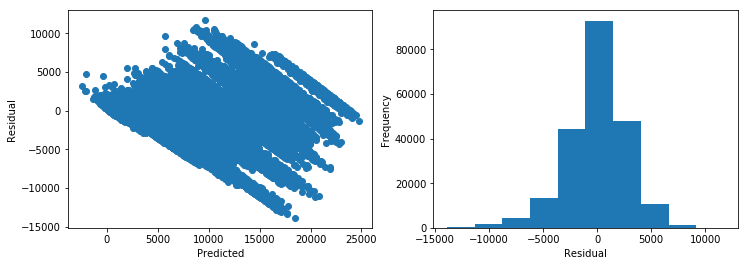

[22:11:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


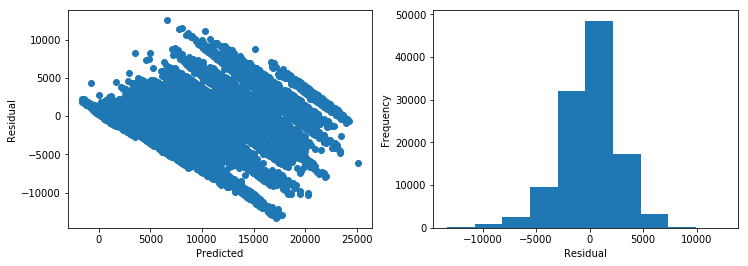

[22:11:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


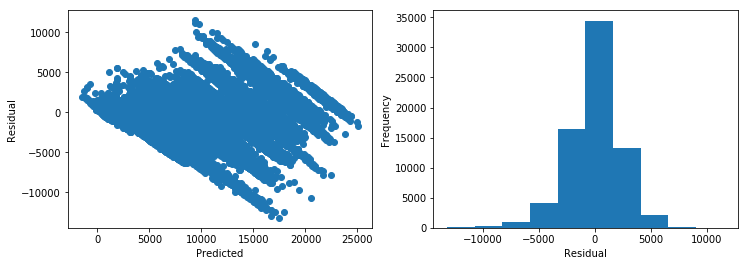

In [42]:
import matplotlib.pyplot as plt
import warnings
%matplotlib inline


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for X_cl_train, X_cl_test, y_cl_train, y_cl_test in zip(X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests):
        X_cl_train = StandardScaler().fit_transform(X_cl_train)
        X_cl_test = StandardScaler().fit_transform(X_cl_test)
        dtrain = xgb.DMatrix(X_cl_train, label=y_cl_train)
        dtest = xgb.DMatrix(X_cl_test, label=y_cl_test)
        bst = xgb.train(param, dtrain, num_round)

        predictions_train = bst.predict(dtrain)
        residuals = y_cl_train - predictions_train
        fig = plt.figure(figsize=(12,4))

        ax1 = fig.add_subplot(121)
        ax1.scatter(predictions_train, residuals)
        ax1.set_xlabel("Predicted")
        ax1.set_ylabel("Residual")

        ax2 = fig.add_subplot(122)
        ax2.hist(residuals)
        ax2.set_xlabel("Residual")
        ax2.set_ylabel("Frequency")
        plt.show()

Text(0, 0.5, 'Frequency')

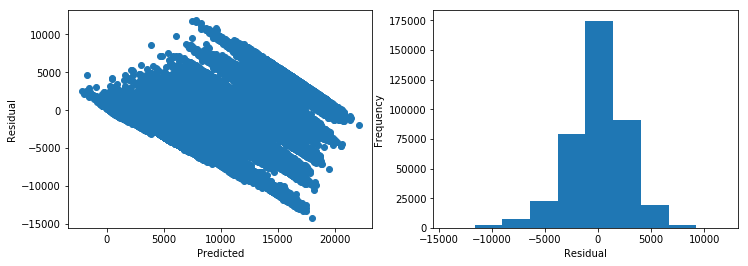

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

predictions_train = bst.predict(dtrain)

residuals = y_s_train - predictions_train

fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.scatter(predictions_train, residuals)
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Residual")

ax2 = fig.add_subplot(122)
ax2.hist(residuals)
ax2.set_xlabel("Residual")
ax2.set_ylabel("Frequency")

### MLP Using Keras

In [104]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(tf.__version__)

1.12.0


In [120]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(25, activation='linear',
                       input_shape=(X_s_train.shape[1],)),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dense(1)
  ])

  optimizer = 'Nadam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 25)                2025      
_________________________________________________________________
dense_5 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 26        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


In [121]:
EPOCHS = 3

# Store training stats
history = model.fit(X_s_train, y_s_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=1)

Train on 319312 samples, validate on 79829 samples
Epoch 1/3
319312/319312 [==============================] - 46s 145us/step - loss: 14609573.4573 - mean_absolute_error: 2761.2182 - val_loss: 8995588.9888 - val_mean_absolute_error: 2278.3298
Epoch 2/3
319312/319312 [==============================] - 43s 135us/step - loss: 8886373.8378 - mean_absolute_error: 2259.2656 - val_loss: 8880380.9692 - val_mean_absolute_error: 2269.3995
Epoch 3/3
319312/319312 [==============================] - 48s 152us/step - loss: 8817892.1439 - mean_absolute_error: 2251.6432 - val_loss: 8823337.5453 - val_mean_absolute_error: 2262.1576


133048/133048 [==============================] - 6s 47us/step


[8739820.381516445, 2244.593371024931]

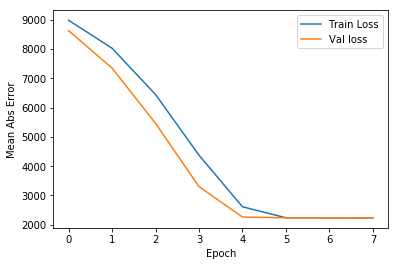

In [107]:
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()

plot_history(history)
model.evaluate(X_s_test, y_s_test)

Text(0, 0.5, 'Frequency')

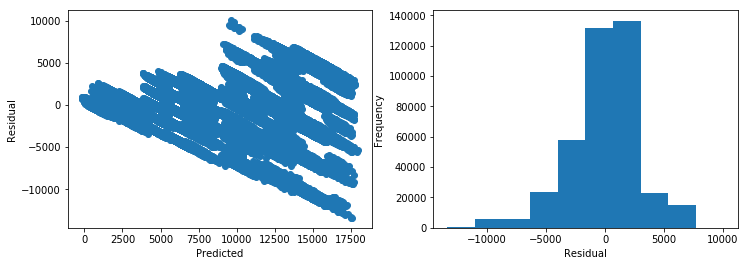

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline

predictions_train = model.predict(X_s_train).T[0]

residuals = y_s_train - predictions_train

fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.scatter(predictions_train, residuals)
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Residual")

ax2 = fig.add_subplot(122)
ax2.hist(residuals)
ax2.set_xlabel("Residual")
ax2.set_ylabel("Frequency")